In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from copy import copy, deepcopy

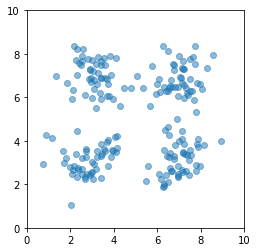

In [32]:
np.random.seed(2932)
nums = 50
x1 = np.random.randn(nums, 2)*0.75 + np.array([3, 3]) 
x2 = np.random.randn(nums, 2)*0.75 + np.array([3, 7]) 
x3 = np.random.randn(nums, 2)*0.75 + np.array([7, 7]) 
x4 = np.random.randn(nums, 2)*0.75 + np.array([7, 3])  
x = np.concatenate([x1, x2, x3, x4])

plt.scatter(x[:, 0], x[:, 1], cmap='bwr', alpha=0.5)
plt.axis('scaled')
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.show()

In [38]:
class KDTree(object):
    def __init__(self, parent, points, area=None, name='root', visited=None):
        self.name = name
        self.parent = parent
        self.points = points
        self.point = None
        self.feature = None
        self.threshold = None
        self.left = None
        self.right = None
        self.area = area # 空间边界
        self.visited = visited # 访问过的列表，所有节点同指向一个列表
        self.flag_leaf = False
        self.create() # 递归让kdtree充分分裂
        return
    
    def show(self):
        print(self.point)
        print(self.feature)
        print(self.threshold)
        print(self.left)
        print(self.right)
        return
    
    def create(self):
        # 选择方差最大的特征，按照这个特征将样本点排序
        if len(self.points)<=1:
            self.flag_leaf = True
            self.point = self.points[0]
            return
        variance = np.var(self.points, axis=0)
        feature = np.argmax(variance)
        self.points = self.points[self.points[:, feature].argsort()]
        # print(self.points)
        
        # 选择中位数作为分裂阈值
        datas = self.points[:, feature] 
        mid = len(datas)//2
        threshold = datas[mid]
        # print(threshold)
        
        # 分成2个子节点集合
        left  = self.points[:mid]
        point = self.points[mid]
        right = self.points[mid+1:]      
        
        # 每个节点按照分裂的阈值，给子节点确定空间边界
        if type(self.parent) == str:
            self.area = np.array([[-np.inf, np.inf]] * self.points.shape[1])
            self.visited = list()
        area = self.area.copy()
        area_left = area.copy()
        area_right = area.copy()
        area_left[feature][1] = threshold
        area_right[feature][0] = threshold
        
        # 保存信息
        self.point = point
        self.feature = feature
        self.threshold = threshold
        
        # 递归生成sub-KDTree
        if len(left)>=1:
            self.left = KDTree(self, left, area_left, self.name+'-L', self.visited) 
        if len(right)>=1:
            self.right = KDTree(self, right, area_right, self.name+'-R', self.visited) 
        return
    
    def compute_distance(self, pnt1, pnt2):
        dis = np.sqrt(np.power(pnt1-pnt2, 2).sum())
        return dis
    
    def find_down(self, node, pnt1):
        # 从 node 节点开始，一路向下搜索到叶节点
        node_res = node
        while True and node_res:
            if node_res.flag_leaf:
                return node_res
            if(pnt1[node.feature]>=node_res.threshold) and node_res.right:
                node_res = node_res.right
            elif node_res.left:
                node_res = node_res.left
            else:
                return node_res
        return node_res

    
    def search(self, pnt):
        # 已访问的节点
        visited = list()
        bst_node = None 
        bst_dis = np.inf 
        
        # 向下搜索
        node = self.find_down(self, pnt)
        dis = self.compute_distance(node.point, pnt)
        visited.append(node)
        bst_node = node 
        bst_dis = dis
        
        for loop in range(100000):
            # 向上搜索
            nodep = node.parent 
            nodeb = [i for i in (nodep.left, nodep.right) if i not in visited and i is not None] 
            mar = np.abs(pnt[nodep.feature] - nodep.threshold) # 样本点到超平面的间隔
            cand1 = mar < bst_dis # 是否交界
            cand2 = len(nodeb)>0 # 是否有另一个分支
            cand3 = nodeb not in visited # 是否已经访问过
            if cand1 and cand2 and cand3:
                node = self.find_down(nodeb[0], pnt)
            else:
                node = nodep
            # 进行判断
            dis = self.compute_distance(node.point, pnt)
            visited.append(node)
            if dis < bst_dis:
                bst_node = node 
                bst_dis = dis
            print(loop, (bst_node.name, bst_node.point, bst_dis, node.name,))
            
            # 如果已经搜索到根节点，则停止迭代
            if node.name == 'root':
                break
        return bst_node
    pass



pnt = [5, 5]
kdt = KDTree('root', x)
tar_node = kdt.search(pnt)

0 ('root-L-L-R-R-R-R', array([4.14405884, 4.22700824]), 1.1533219532362846, 'root-L-L-R-R-R-R')
1 ('root-L-L-R-R-R-R', array([4.14405884, 4.22700824]), 1.1533219532362846, 'root-L-L-R-R-R')
2 ('root-L-L-R-R-R-R', array([4.14405884, 4.22700824]), 1.1533219532362846, 'root-L-L-R-R')
3 ('root-L-L-R-R-R-R', array([4.14405884, 4.22700824]), 1.1533219532362846, 'root-L-L-R')
4 ('root-L-L-R-R-R-R', array([4.14405884, 4.22700824]), 1.1533219532362846, 'root-L-L')
5 ('root-L-L-R-R-R-R', array([4.14405884, 4.22700824]), 1.1533219532362846, 'root-L-R-L-R-R-R-L')
6 ('root-L-L-R-R-R-R', array([4.14405884, 4.22700824]), 1.1533219532362846, 'root-L-R-L-R-R-R')
7 ('root-L-L-R-R-R-R', array([4.14405884, 4.22700824]), 1.1533219532362846, 'root-L-R-L-R-R-L-L')
8 ('root-L-L-R-R-R-R', array([4.14405884, 4.22700824]), 1.1533219532362846, 'root-L-R-L-R-R-L')
9 ('root-L-R-L-R-R', array([4.28939145, 5.61404405]), 0.9391563315411194, 'root-L-R-L-R-R')
10 ('root-L-R-L-R-R', array([4.28939145, 5.61404405]), 0.939

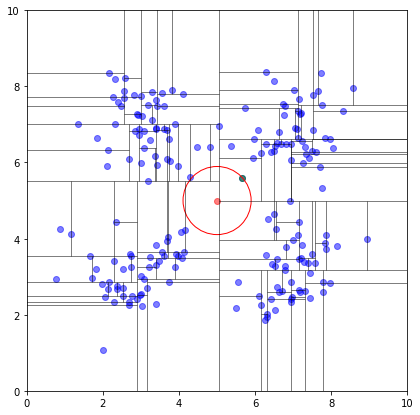

In [39]:
# 画出kdtree 的决策界面
# 广度优先搜索

fig, ax = plt.subplots(1, 1)
fig.set_figwidth(7)
fig.set_figheight(7)

rad = tar_node.compute_distance(tar_node.point, pnt)
circle = Circle(pnt, radius=rad, facecolor="None", edgecolor="red", linewidth=1)
ax.add_patch(circle)

stack = list()
stack.append(kdt)
while len(stack)>0:
    node = stack.pop(-1)
    for item in [node.left, node.right]:
        if item:
            stack.insert(0, item)
    # print(node.name, node.feature)
    if node.feature is not None:
        f = node.feature
        v = node.threshold
        f2 = (f+1)%2
        # print(node.name, node.feature, f, v, f2)
        c_min, c_max = node.area[f2]
        c_min = np.max([c_min, -100.0])
        c_max = np.min([c_max, 100.0])
        if f==0:
            plt.vlines(v, c_min, c_max, colors='black', alpha=0.5, linewidth=1)
        if f==1:
            plt.hlines(v, c_min, c_max, colors='black', alpha=0.5, linewidth=1)

            
plt.scatter(x[:, 0], x[:, 1], c='b', alpha=0.5)
tar = tar_node.point
plt.scatter([tar[0]], [tar[1]], c='green', alpha=0.5)
plt.scatter([pnt[0]], [pnt[1]], c='red', alpha=0.5)

plt.axis('scaled')
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.show()
plt.show()